In [1]:
import pickle
import pandas as pd
import copy
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from dateutil.relativedelta import relativedelta
from utils import *
import xgboost as xgb

with open('basket_data.pkl', 'rb') as file:
    save_dict = pickle.load(file)
    
players_df = pd.DataFrame(save_dict['player_games'])
players_df.head(5)

,#,%_1PT,%_2PT,%_3PT,AS,A_1PT,A_2PT,A_3PT,BKA_Blocks,BKF_Blocks,...,ST,TO,TR_Rebounds,VAL,game_id,game_name,player_id,player_name,team_id,team_name
0,1.0,0.667,0.667,0.00,2,3,3,1,1.0,1.0,...,3,1,2,9.0,2963,M. Tel-Aviv (A) L,3,Matan Naor,37,hapoel migdal jerusalem (coach: dan shamir)
1,3.0,0.000,0.500,0.75,1,1,4,8,0.0,0.0,...,3,1,3,20.0,2973,Ashkelon (H) W,3,Matan Naor,37,hapoel migdal jerusalem (coach: dan shamir)
2,18.0,0.000,1.000,0.00,0,0,1,0,0.0,0.0,...,0,0,0,1.0,3045,M. Rishon (A) W,3,Matan Naor,37,hapoel migdal jerusalem (coach: dan shamir)
3,20.0,1.000,0.000,0.00,0,2,0,1,0.0,0.0,...,0,0,0,1.0,3124,M. Tel-Aviv (A) L,3,Matan Naor,37,hapoel migdal jerusalem (coach: dan shamir)
4,23.0,0.000,0.000,0.00,0,0,0,0,0.0,0.0,...,0,0,0,-2.0,3136,Nahariya (A) L,3,Matan Naor,37,hapoel migdal jerusalem (coach: dan shamir)


# loading DataFrames:

In [4]:
players_df = pd.read_pickle('players_df')
players_df_small = pd.read_pickle('players_df')
games_df = pd.read_pickle('games_df')
winner_df = pd.read_pickle('winner_games.pkl')
winner_df = pd.DataFrame(winner_df)

# creating data

In [7]:
relevant_cols_for_mean = ['%_1PT', '%_2PT', '%_3PT', 'AS', 'A_1PT', 'A_2PT', 'A_3PT',
                          'BKA_Blocks', 'BKF_Blocks', 'DR_Rebounds', 'FA_Fouls', 'M_1PT', 'M_2PT',
                          'M_3PT', 'Min', 'OR_Rebounds', 'PF_Fouls', 'Pts', 'SF', 'ST', 'TO',
                          'TR_Rebounds', 'VAL']

new_cols = []
dict_list = []
# new_cols.append('player_id')
new_cols.append('game_id')
for relevant_col in relevant_cols_for_mean:
    new_cols.append(relevant_col + '_total_home_sum')
    new_cols.append(relevant_col + '_total_away_sum')
    new_cols.append(relevant_col + '_total_home_len')
    new_cols.append(relevant_col + '_total_away_len')
    new_cols.append(relevant_col + '_total_home_avg')
    new_cols.append(relevant_col + '_total_away_avg')
    new_cols.append(relevant_col + 'is_total_home_avg_nan')
    new_cols.append(relevant_col + 'is_total_away_avg_nan')
    for k in range(13):
        new_cols.append('player_home' + str(k) + '_' + relevant_col + '_last_mean')
        new_cols.append('player_away' + str(k) + '_' + relevant_col + '_last_mean')
        new_cols.append('player_home' + str(k) + '_' + relevant_col + '_not_nan_length')
        new_cols.append('player_away' + str(k) + '_' + relevant_col + '_not_nan_length')

new_df = pd.DataFrame(columns=new_cols)
count = 0
for index, game_line in tqdm(games_df.iterrows()):
    val_dict = {}
    val_dict['game_id'] = game_line['game_id']
    
    # home players' stats
    sums1 = {}
    sums2 = {}
    for relevant_col in relevant_cols_for_mean:
        sums1[relevant_col] = 0
        sums2[relevant_col] = 0
    
    for k in range(13):

        col_name = 'player_home' + str(k)
        player_id = game_line[col_name]
        game_date = game_line['datr']
        player_relevant_lines = players_df[players_df['player_id'] == str(player_id)]
        player_relevant_lines = player_relevant_lines[np.logical_and(player_relevant_lines['datr'] < game_date,
                                                                     player_relevant_lines['datr'] > game_date +
                                                                     relativedelta(months=-2))]
        
        for relevant_col in relevant_cols_for_mean:
            player_mean_stats_for_col, num_valid_lines = get_mean_stats(relevant_col, player_relevant_lines)
            val_dict[col_name + '_' + relevant_col + '_last_mean'] = player_mean_stats_for_col
            val_dict[col_name + '_' + relevant_col + '_not_nan_length'] = num_valid_lines
            sums1[relevant_col] += player_mean_stats_for_col
            sums2[relevant_col] += num_valid_lines
    
    for relevant_col in relevant_cols_for_mean:
        val_dict[relevant_col + '_total_home_sum'] = sums1[relevant_col]
        val_dict[relevant_col + '_total_home_len'] = sums2[relevant_col]
        if not sums2[relevant_col] == 0:
            val_dict[relevant_col + '_total_home_avg'] = sums1[relevant_col]/sums2[relevant_col]
            val_dict[relevant_col + 'is_total_home_avg_nan'] = 0
        else:
            val_dict[relevant_col + '_total_home_avg'] = 0
            val_dict[relevant_col + 'is_total_home_avg_nan'] = 1
    
    # away players' stats:
    sums1 = {}
    sums2 = {}
    for relevant_col in relevant_cols_for_mean:
        sums1[relevant_col] = 0
        sums2[relevant_col] = 0
    
    for k in range(13):

        col_name = 'player_away' + str(k)
        player_id = game_line[col_name]
        game_date = game_line['datr']
        player_relevant_lines = players_df[players_df['player_id'] == str(player_id)]
        player_relevant_lines = player_relevant_lines[np.logical_and(player_relevant_lines['datr'] < game_date,
                                                                         player_relevant_lines['datr'] > game_date +
                                                                         relativedelta(months=-2))]

        for relevant_col in relevant_cols_for_mean:
            player_mean_stats_for_col, num_valid_lines = get_mean_stats(relevant_col, player_relevant_lines)
            val_dict[col_name + '_' + relevant_col + '_last_mean'] = player_mean_stats_for_col
            val_dict[col_name + '_' + relevant_col + '_not_nan_length'] = num_valid_lines
            sums1[relevant_col] += player_mean_stats_for_col
            sums2[relevant_col] += num_valid_lines
    
    for relevant_col in relevant_cols_for_mean:
        val_dict[relevant_col + '_total_away_sum'] = sums1[relevant_col]
        val_dict[relevant_col + '_total_away_len'] = sums2[relevant_col]
        if not sums2[relevant_col] == 0:
            val_dict[relevant_col + '_total_away_avg'] = sums1[relevant_col]/sums2[relevant_col]
            val_dict[relevant_col + 'is_total_away_avg_nan'] = 0
        else:
            val_dict[relevant_col + '_total_home_avg'] = 0
            val_dict[relevant_col + 'is_total_away_avg_nan'] = 1
    
    dict_list.append(val_dict)

new_df = pd.DataFrame(dict_list)
games_df = games_df.merge(new_df, on='game_id')
games_df

c:\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,away_team_id,away_team_name,away_team_points,datr,game_id,home_team_id,home_team_name,home_team_points,player_away0,player_away1,...,player_home9_SF_last_mean,player_home9_SF_not_nan_length,player_home9_ST_last_mean,player_home9_ST_not_nan_length,player_home9_TO_last_mean,player_home9_TO_not_nan_length,player_home9_TR_Rebounds_last_mean,player_home9_TR_Rebounds_not_nan_length,player_home9_VAL_last_mean,player_home9_VAL_not_nan_length
0,326,Maccabi Haifa (Coach: Rani Kahana),93,1990-09-23,3463,397,Hapoel Tel Aviv (Coach: Yariv Varshitzki),104,6850,6848,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
1,355,Ramat Hasharon (Coach: israel Lev),103,1990-09-23,3461,180,Galil Elion (Coach: Muli Katzurin),105,6862,6867,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
2,739,Hapoel Holon (Coach: Effi Birenboim),86,1990-09-23,3464,222,Ramat Gan (Coach: Pini Gershon),81,6907,6910,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
3,541,Hapoel Gvat (Coach: Boaz Yanai),59,1990-09-23,3462,141,Hapoel Jerusalem (Coach: Yoram Harush),93,6895,6897,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
4,242,Rishon Letsion (Coach: Moshe Veinkrantz),105,1990-09-23,3460,495,Beitar Tel Aviv (Coach: Eli Kanetti),93,6840,6841,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
5,397,Hapoel Tel Aviv (Coach: Yariv Varshitzki),94,1990-09-30,3466,739,Hapoel Holon (Coach: Effi Birenboim),84,6878,6873,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
6,355,Ramat Hasharon (Coach: israel Lev),88,1990-10-01,3468,242,Rishon Letsion (Coach: Moshe Veinkrantz),89,6862,6867,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
7,180,Galil Elion (Coach: Muli Katzurin),92,1990-10-01,3467,326,Maccabi Haifa (Coach: Rani Kahana),98,6816,6824,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
8,141,Hapoel Jerusalem (Coach: Yoram Harush),89,1990-10-01,3469,116,Maccabi Tel-Aviv (Coach: Zvika Sherf),66,6808,6807,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
9,222,Ramat Gan (Coach: Pini Gershon),105,1990-10-01,3465,541,Hapoel Gvat (Coach: Boaz Yanai),95,6828,6833,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0


# Save extended data:

In [10]:
games_df.to_pickle('games_df_extended')
players_df.to_pickle('players_df_extended')

In [9]:
games_df.sort_values(by='datr')

,away_team_id,away_team_name,away_team_points,datr,game_id,home_team_id,home_team_name,home_team_points,player_away0,player_away1,...,player_home9_SF_last_mean,player_home9_SF_not_nan_length,player_home9_ST_last_mean,player_home9_ST_not_nan_length,player_home9_TO_last_mean,player_home9_TO_not_nan_length,player_home9_TR_Rebounds_last_mean,player_home9_TR_Rebounds_not_nan_length,player_home9_VAL_last_mean,player_home9_VAL_not_nan_length
0,326,Maccabi Haifa (Coach: Rani Kahana),93,1990-09-23,3463,397,Hapoel Tel Aviv (Coach: Yariv Varshitzki),104,6850,6848,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
4450,242,Rishon Letsion (Coach: Moshe Veinkrantz),105,1990-09-23,11113460,495,Beitar Tel Aviv (Coach: Eli Kanetti),88,6840,6841,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
4449,242,Rishon Letsion (Coach: Moshe Veinkrantz),97,1990-09-23,11103460,495,Beitar Tel Aviv (Coach: Eli Kanetti),93,0,6841,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
4448,242,Rishon Letsion (Coach: Moshe Veinkrantz),97,1990-09-23,11103460,495,Beitar Tel Aviv (Coach: Eli Kanetti),93,0,6841,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
4447,242,Rishon Letsion (Coach: Moshe Veinkrantz),105,1990-09-23,11103460,495,Beitar Tel Aviv (Coach: Eli Kanetti),84,6840,6841,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
4446,242,Rishon Letsion (Coach: Moshe Veinkrantz),105,1990-09-23,11103460,495,Beitar Tel Aviv (Coach: Eli Kanetti),84,6840,6841,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
4445,541,Hapoel Gvat (Coach: Boaz Yanai),59,1990-09-23,11193462,141,Hapoel Jerusalem (Coach: Yoram Harush),85,6895,6897,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
4444,541,Hapoel Gvat (Coach: Boaz Yanai),59,1990-09-23,11183462,141,Hapoel Jerusalem (Coach: Yoram Harush),84,6895,6897,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
4443,541,Hapoel Gvat (Coach: Boaz Yanai),59,1990-09-23,11173462,141,Hapoel Jerusalem (Coach: Yoram Harush),86,6895,6897,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0
4442,541,Hapoel Gvat (Coach: Boaz Yanai),59,1990-09-23,11163462,141,Hapoel Jerusalem (Coach: Yoram Harush),88,6895,6897,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.00000,0


# train-test split:

In [7]:
games_df = games_df.sort_values(by='datr')
games_df_train = copy.deepcopy(games_df[:int(len(games_df)*0.8)])
games_df_val = copy.deepcopy(games_df[int(len(games_df)*0.8):len(games_df)])

games_df_train = games_df_train.drop('away_team_name', axis=1)
games_df_train = games_df_train.drop('home_team_name', axis=1)
games_df_train_full = copy.deepcopy(games_df_train)
games_df_train = games_df_train.drop('datr', axis=1)
games_df_train = games_df_train.drop('game_id', axis=1)

games_df_val = games_df_val.drop('away_team_name', axis=1)
games_df_val = games_df_val.drop('home_team_name', axis=1)
games_df_val_full = copy.deepcopy(games_df_val)
games_df_val = games_df_val.drop('datr', axis=1)
games_df_val = games_df_val.drop('game_id', axis=1)


games_df_train_y_home = games_df_train['home_team_points'].tolist()
games_df_train_y_away = games_df_train['away_team_points'].tolist()

games_df_val_y_home = games_df_val['home_team_points'].tolist()
games_df_val_y_away = games_df_val['away_team_points'].tolist()

games_df_train_x = games_df_train.drop('home_team_points', axis=1)
games_df_train_x = games_df_train_x.drop('away_team_points', axis=1)

games_df_val_x = games_df_val.drop('home_team_points', axis=1)
games_df_val_x = games_df_val_x.drop('away_team_points', axis=1)

for col in games_df_train_x.columns:
    games_df_train_x[col] = games_df_train_x[col].astype(float)
    games_df_val_x[col] = games_df_val_x[col].astype(float)

# Train: predict home score and away score seperately

In [16]:

eval_set_home = [(games_df_val_x, games_df_val_y_home), (games_df_train_x, games_df_train_y_home)]
eval_set_away = [(games_df_val_x, games_df_val_y_away), (games_df_train_x, games_df_train_y_home)]

reg_home = xgb.XGBRegressor(n_estimators=200, max_depth=10, num_round = 100, seed=1, eval_set=eval_set_home, verbose_eval=True, eta= 0.3, min_child_weight=1, learning_rate=0.05, subsample=0.1, colsample_bytree=1, eval_metric='rmse')
reg_away = xgb.XGBRegressor(n_estimators=200, max_depth=10, num_round = 100, seed=1, eval_set=eval_set_away, verbose_eval=True, eta= 0.3, min_child_weight=1, learning_rate=0.05, subsample=0.1, colsample_bytree=1, eval_metric='rmse')

reg_home.fit(games_df_train_x, games_df_train_y_home, early_stopping_rounds=40, eval_set=eval_set_home, verbose=True, eval_metric='mae')
reg_away.fit(games_df_train_x, games_df_train_y_away, early_stopping_rounds=40, eval_set=eval_set_away, verbose=True, eval_metric='mae')

results_home = reg_home.evals_result()
results_away = reg_away.evals_result()

[0]	validation_0-mae:78.7627	validation_1-mae:79.6616
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 40 rounds.
[1]	validation_0-mae:76.6245	validation_1-mae:75.6824
[2]	validation_0-mae:72.7953	validation_1-mae:71.8532
[3]	validation_0-mae:71.3667	validation_1-mae:68.298
[4]	validation_0-mae:67.9573	validation_1-mae:64.901
[5]	validation_0-mae:64.824	validation_1-mae:61.6562
[6]	validation_0-mae:63.7124	validation_1-mae:58.6086
[7]	validation_0-mae:62.8792	validation_1-mae:55.6795
[8]	validation_0-mae:60.1283	validation_1-mae:52.8926
[9]	validation_0-mae:58.411	validation_1-mae:50.3812
[10]	validation_0-mae:55.9524	validation_1-mae:47.9333
[11]	validation_0-mae:53.715	validation_1-mae:45.6115
[12]	validation_0-mae:52.5129	validation_1-mae:43.3957
[13]	validation_0-mae:50.931	validation_1-mae:41.2818
[14]	validation_0-mae:49.1882	validation_1-mae:39.2751
[15]	validation_0-mae:47.4512	vali

[147]	validation_0-mae:14.533	validation_1-mae:6.08943
[148]	validation_0-mae:14.5101	validation_1-mae:6.06365
[149]	validation_0-mae:14.5117	validation_1-mae:6.04526
[150]	validation_0-mae:15.1782	validation_1-mae:6.04207
[151]	validation_0-mae:15.226	validation_1-mae:6.02133
[152]	validation_0-mae:15.2448	validation_1-mae:6.00977
[153]	validation_0-mae:15.2944	validation_1-mae:5.99465
[154]	validation_0-mae:15.3183	validation_1-mae:5.97813
[155]	validation_0-mae:15.3511	validation_1-mae:5.95746
[156]	validation_0-mae:15.4006	validation_1-mae:5.94143
[157]	validation_0-mae:15.7099	validation_1-mae:5.92066
[158]	validation_0-mae:16.2904	validation_1-mae:5.90282
[159]	validation_0-mae:16.2723	validation_1-mae:5.88604
[160]	validation_0-mae:16.2778	validation_1-mae:5.86858
[161]	validation_0-mae:16.2827	validation_1-mae:5.85627
[162]	validation_0-mae:16.3182	validation_1-mae:5.8343
[163]	validation_0-mae:16.2796	validation_1-mae:5.81341
[164]	validation_0-mae:16.6973	validation_1-mae:5.7

[93]	validation_0-mae:10.6339	validation_1-mae:10.8982
[94]	validation_0-mae:10.6199	validation_1-mae:10.899
[95]	validation_0-mae:10.6015	validation_1-mae:10.8938
[96]	validation_0-mae:10.598	validation_1-mae:10.8766
[97]	validation_0-mae:10.6085	validation_1-mae:10.8955
[98]	validation_0-mae:10.7674	validation_1-mae:10.8712
[99]	validation_0-mae:11.1421	validation_1-mae:10.8485
[100]	validation_0-mae:11.5017	validation_1-mae:10.8382
[101]	validation_0-mae:11.5292	validation_1-mae:10.8362
[102]	validation_0-mae:11.5295	validation_1-mae:10.8141
[103]	validation_0-mae:11.4875	validation_1-mae:10.7994
[104]	validation_0-mae:11.5096	validation_1-mae:10.7954
[105]	validation_0-mae:11.9904	validation_1-mae:10.7706
[106]	validation_0-mae:11.9954	validation_1-mae:10.7708
[107]	validation_0-mae:12.0749	validation_1-mae:10.7655
[108]	validation_0-mae:12.3097	validation_1-mae:10.7684
[109]	validation_0-mae:12.3183	validation_1-mae:10.7637
[110]	validation_0-mae:12.3552	validation_1-mae:10.7698
[

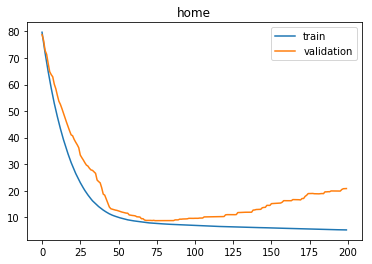

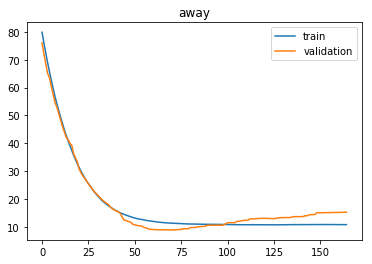

In [21]:
home_train_results = results_home['validation_1']['mae']
home_val_results = results_home['validation_0']['mae']
away_train_results = results_away['validation_1']['mae']
away_val_results = results_away['validation_0']['mae']

plt.figure()
plt.title('home')
plt.plot(home_train_results, label='train')
plt.plot(home_val_results, label='validation')
plt.legend()
plt.figure()
plt.title('away')
plt.plot(away_train_results, label='train')
plt.plot(away_val_results, label='validation')
plt.legend()

# plot feature importance:

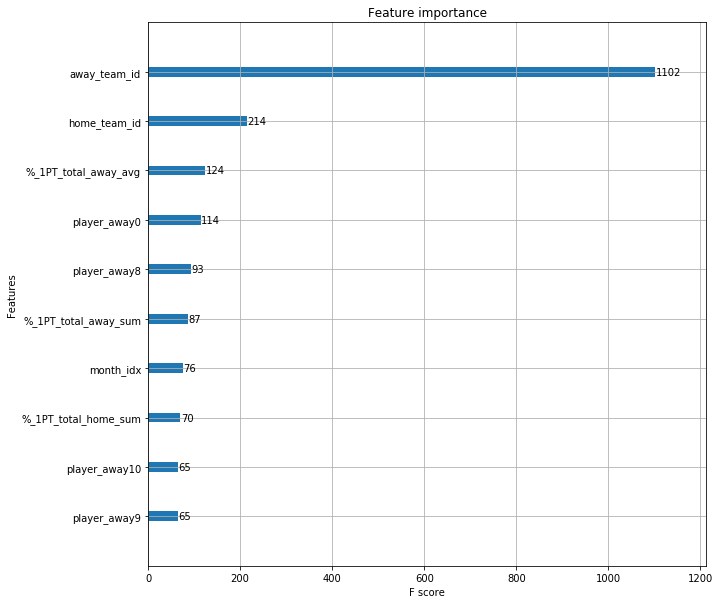

In [5]:
import matplotlib.pyplot as plt
x=xgb.plot_importance(reg_home, max_num_features=10)
x.figure.set_size_inches(10, 10)

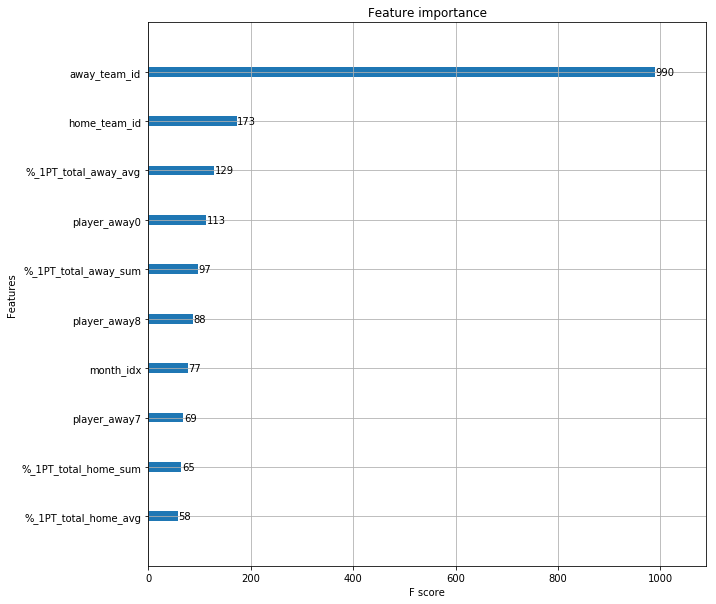

In [6]:
import matplotlib.pyplot as plt
x=xgb.plot_importance(reg_away, max_num_features=10)
x.figure.set_size_inches(10, 10)

# see selected example of prediction of both home and away scores:

In [7]:
idx = 105
example = games_df_val_x[idx:(idx + 1)]
(example)
print('home score: ' + str(games_df_val_y_home[idx:(idx + 1)]))
print('away score: ' + str(games_df_val_y_away[idx:(idx + 1)]))

print('home score: ' + str(reg_home.predict(example)))
print('away score: ' + str(reg_away.predict(example)))

home score: [83]
away score: [73]
home score: [86.024445]
away score: [75.877266]


# Train to predict difference between home score and away score

In [23]:
games_df_train = copy.deepcopy(games_df[:int(len(games_df)*0.8)])
games_df_val = copy.deepcopy(games_df[int(len(games_df)*0.8):len(games_df)])

games_df_train = games_df_train.drop('away_team_name', axis=1)
games_df_train = games_df_train.drop('home_team_name', axis=1)
games_df_train = games_df_train.drop('game_id', axis=1)
games_df_train = games_df_train.drop('datr', axis=1)
games_df_train['score_diff'] = games_df_train['home_team_points'] - games_df_train['away_team_points'] 

games_df_val = games_df_val.drop('away_team_name', axis=1)
games_df_val = games_df_val.drop('home_team_name', axis=1)
games_df_val = games_df_val.drop('game_id', axis=1)
games_df_val = games_df_val.drop('datr', axis=1)
games_df_val['score_diff'] = games_df_val['home_team_points'] - games_df_val['away_team_points'] 


games_df_train_y_diff = games_df_train['score_diff'].tolist()

games_df_val_y_diff = games_df_val['score_diff'].tolist()

games_df_train_x = games_df_train.drop('home_team_points', axis=1)
games_df_train_x = games_df_train_x.drop('away_team_points', axis=1)
games_df_train_x = games_df_train_x.drop('score_diff', axis=1)


games_df_val_x = games_df_val.drop('home_team_points', axis=1)
games_df_val_x = games_df_val_x.drop('away_team_points', axis=1)
games_df_val_x = games_df_val_x.drop('score_diff', axis=1)


for col in games_df_train_x.columns:
    games_df_train_x[col] = games_df_train_x[col].astype(float)
    games_df_val_x[col] = games_df_val_x[col].astype(float)

In [24]:
import xgboost as xgb
eval_set_diff = [(games_df_val_x, games_df_val_y_diff), (games_df_train_x, games_df_train_y_diff)]

reg_diff = xgb.XGBRegressor(n_estimators=500, max_depth=100, num_round = 300, seed=123, eval_set=eval_set_diff, verbose_eval=True, eta= 0.3, min_child_weight=1, learning_rate=0.01, subsample=0.1, colsample_bytree=1, eval_metric='rmse')
reg_diff.fit(games_df_train_x, games_df_train_y_diff, early_stopping_rounds=40, eval_set=eval_set_diff, verbose=True, eval_metric='mae')
results_away = reg_away.evals_result()

[0]	validation_0-mae:10.7338	validation_1-mae:11.9164
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 40 rounds.
[1]	validation_0-mae:10.7054	validation_1-mae:11.8928
[2]	validation_0-mae:10.5999	validation_1-mae:11.8619
[3]	validation_0-mae:10.5818	validation_1-mae:11.8349
[4]	validation_0-mae:10.5783	validation_1-mae:11.8092
[5]	validation_0-mae:10.5649	validation_1-mae:11.7817
[6]	validation_0-mae:10.5141	validation_1-mae:11.7562
[7]	validation_0-mae:10.4983	validation_1-mae:11.7308
[8]	validation_0-mae:10.4929	validation_1-mae:11.7025
[9]	validation_0-mae:10.5793	validation_1-mae:11.674
[10]	validation_0-mae:10.5435	validation_1-mae:11.6455
[11]	validation_0-mae:10.5325	validation_1-mae:11.6214
[12]	validation_0-mae:10.6224	validation_1-mae:11.5954
[13]	validation_0-mae:10.7154	validation_1-mae:11.5696
[14]	validation_0-mae:10.6236	validation_1-mae:11.5458
[15]	validation_0-mae:10.6106

[146]	validation_0-mae:12.1432	validation_1-mae:9.29087
[147]	validation_0-mae:12.145	validation_1-mae:9.2787
[148]	validation_0-mae:12.1242	validation_1-mae:9.26979
[149]	validation_0-mae:12.1341	validation_1-mae:9.25658
[150]	validation_0-mae:12.3081	validation_1-mae:9.24226
[151]	validation_0-mae:12.3005	validation_1-mae:9.22843
[152]	validation_0-mae:12.4462	validation_1-mae:9.22071
[153]	validation_0-mae:12.5411	validation_1-mae:9.20874
[154]	validation_0-mae:12.4092	validation_1-mae:9.19724
[155]	validation_0-mae:12.4108	validation_1-mae:9.18738
[156]	validation_0-mae:12.2842	validation_1-mae:9.17518
[157]	validation_0-mae:12.1584	validation_1-mae:9.16479
[158]	validation_0-mae:12.1576	validation_1-mae:9.15185
[159]	validation_0-mae:12.1223	validation_1-mae:9.13813
[160]	validation_0-mae:12.0377	validation_1-mae:9.12413
[161]	validation_0-mae:12.0343	validation_1-mae:9.11036
[162]	validation_0-mae:12.0318	validation_1-mae:9.09971
[163]	validation_0-mae:12.1533	validation_1-mae:9.

[293]	validation_0-mae:13.2301	validation_1-mae:7.91273
[294]	validation_0-mae:13.2951	validation_1-mae:7.90495
[295]	validation_0-mae:13.2944	validation_1-mae:7.89887
[296]	validation_0-mae:13.2887	validation_1-mae:7.89197
[297]	validation_0-mae:13.1683	validation_1-mae:7.88337
[298]	validation_0-mae:13.2866	validation_1-mae:7.87358
[299]	validation_0-mae:13.1736	validation_1-mae:7.86612
[300]	validation_0-mae:13.3247	validation_1-mae:7.85543
[301]	validation_0-mae:13.4737	validation_1-mae:7.84683
[302]	validation_0-mae:13.4237	validation_1-mae:7.8381
[303]	validation_0-mae:13.342	validation_1-mae:7.83089
[304]	validation_0-mae:13.3438	validation_1-mae:7.82503
[305]	validation_0-mae:13.341	validation_1-mae:7.81743
[306]	validation_0-mae:13.2815	validation_1-mae:7.80959
[307]	validation_0-mae:13.2831	validation_1-mae:7.8045
[308]	validation_0-mae:13.2803	validation_1-mae:7.79806
[309]	validation_0-mae:13.3921	validation_1-mae:7.79085
[310]	validation_0-mae:13.3038	validation_1-mae:7.78

[440]	validation_0-mae:13.4607	validation_1-mae:6.95031
[441]	validation_0-mae:13.4609	validation_1-mae:6.94526
[442]	validation_0-mae:13.4639	validation_1-mae:6.94051
[443]	validation_0-mae:13.407	validation_1-mae:6.93589
[444]	validation_0-mae:13.4062	validation_1-mae:6.92933
[445]	validation_0-mae:13.4019	validation_1-mae:6.9225
[446]	validation_0-mae:13.4022	validation_1-mae:6.91705
[447]	validation_0-mae:13.3964	validation_1-mae:6.91283
[448]	validation_0-mae:13.3889	validation_1-mae:6.90686
[449]	validation_0-mae:13.3902	validation_1-mae:6.90007
[450]	validation_0-mae:13.3928	validation_1-mae:6.89457
[451]	validation_0-mae:13.3898	validation_1-mae:6.88871
[452]	validation_0-mae:13.3858	validation_1-mae:6.88425
[453]	validation_0-mae:13.3781	validation_1-mae:6.87991
[454]	validation_0-mae:13.4774	validation_1-mae:6.87443
[455]	validation_0-mae:13.5878	validation_1-mae:6.8667
[456]	validation_0-mae:13.4923	validation_1-mae:6.86179
[457]	validation_0-mae:13.4951	validation_1-mae:6.8

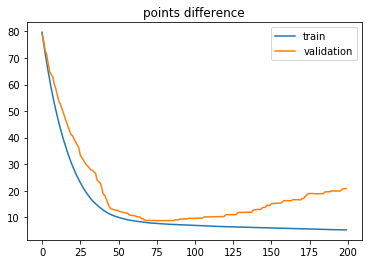

In [25]:
diff_train_results = results_home['validation_1']['mae']
diff_val_results = results_home['validation_0']['mae']

plt.figure()
plt.title('points difference')
plt.plot(diff_train_results, label='train')
plt.plot(diff_val_results, label='validation')
plt.legend()

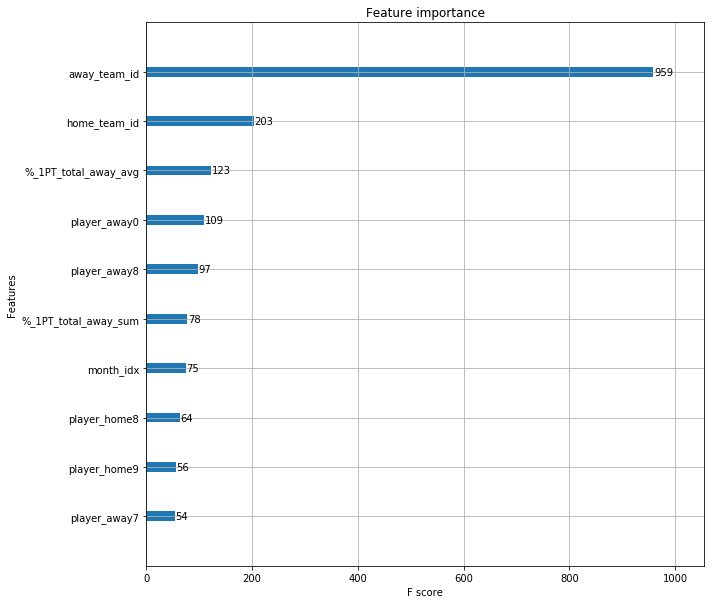

In [11]:
import matplotlib.pyplot as plt
x=xgb.plot_importance(reg_diff, max_num_features=10)
x.figure.set_size_inches(10, 10)

In [15]:
idx = 100
example = games_df_val_x[idx:(idx + 1)]
(example)
print('home score: ' + str(games_df_val_y_home[idx:(idx + 1)]))
print('away score: ' + str(games_df_val_y_away[idx:(idx + 1)]))
print('score diff: ' + str(games_df_val_y_home[idx:(idx + 1)][0] - games_df_val_y_away[idx:(idx + 1)][0]))

print('predicted score diff: ' + str(reg_diff.predict(example)))

home score: [89]
away score: [100]
score diff: -11
predicted score diff: [3.7740946]


In [9]:
winner_df.head(15)

,advantage,date,points,score,teams
0,"[-2, -3, -4]",2018-12-27,[166],"[107, 99]","[מכבי ראשון לציון, הפועל גליל גלבוע]"
1,[-6],2018-12-26,[168],"[94, 74]","[הפועל ירושלים, הפועל חולון]"
2,"[-4, -5, -6]",2018-12-26,"[164, 165, 166]","[81, 79]","[עירוני נס ציונה, בני הרצליה]"
3,[-5],2018-12-26,[163],"[88, 66]","[הפועל אילת, הפועל באר שבע]"
4,"[9, 8]",2018-12-22,[167],"[64, 87]","[מכבי אשדוד, הפועל ירושלים]"
5,"[2, 1, 0]",2018-12-21,[164],"[74, 92]","[הפועל תל אביב, הפועל חולון]"
6,[],2018-12-21,[],"[74, 92]","[הפועל תל אביב, הפועל חולון]"
7,"[-6, -5]",2018-12-17,[162],"[87, 70]","[הפועל באר שבע, מכבי אשדוד]"
8,"[-5, -4, -3]",2018-12-17,"[158, 159, 160]","[74, 67]","[בני הרצליה, מכבי ראשון לציון]"
9,"[-3, -4]",2018-12-17,[170],"[70, 88]","[הפועל גליל גלבוע, הפועל אילת]"


In [17]:
for index, winner_line in tqdm(winner_df.iterrows()):
    date = winner_line['date']
    game_line = games_df_val_full[games_df_val_full['datr'] == date]
    team_score1 = winner_line['score'][0]
    team_score2 = winner_line['score'][1]
    pred_score_diff = reg_diff.predict(game_line)

[{'teams': ['מכבי ראשון לציון', 'הפועל גליל גלבוע'],
  'date': datetime.datetime(2018, 12, 27, 0, 0),
  'points': [166],
  'advantage': [-2, -3, -4],
  'score': [107, 99]},
 {'teams': ['הפועל ירושלים', 'הפועל חולון'],
  'date': datetime.datetime(2018, 12, 26, 0, 0),
  'points': [168],
  'advantage': [-6],
  'score': [94, 74]},
 {'teams': ['עירוני נס ציונה', 'בני הרצליה'],
  'date': datetime.datetime(2018, 12, 26, 0, 0),
  'points': [164, 165, 166],
  'advantage': [-4, -5, -6],
  'score': [81, 79]},
 {'teams': ['הפועל אילת', 'הפועל באר שבע'],
  'date': datetime.datetime(2018, 12, 26, 0, 0),
  'points': [163],
  'advantage': [-5],
  'score': [88, 66]},
 {'teams': ['מכבי אשדוד', 'הפועל ירושלים'],
  'date': datetime.datetime(2018, 12, 22, 0, 0),
  'points': [167],
  'advantage': [9, 8],
  'score': [64, 87]},
 {'teams': ['הפועל תל אביב', 'הפועל חולון'],
  'date': datetime.datetime(2018, 12, 21, 0, 0),
  'points': [164],
  'advantage': [2, 1, 0],
  'score': [74, 92]},
 {'teams': ['הפועל תל א